final project- Meyrav Dayan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [80]:
## loading the data ##
train = pd.read_csv("./train.csv", header=0)  #loading train
train_labels = train['label']
train_df = train.drop(['label'], axis=1)
test_data = pd.read_csv("./test_without_target.csv", header=0)  #loading test

In [87]:
test_data = test_data.drop(['Unnamed: 0'], axis=1)
print(test_data.shape)


(7387, 25)


# Part 1 and 2 - Data exploration and preprocessing:

In [88]:
##tyding of data:
#leaning the string from Feature 14 and convering into float type:
train_df['Feature_14'] = train_df['Feature_14'].str.replace('mm', '').astype('float')
test_data['Feature_14'] = test_data['Feature_14'].str.replace('mm', '').astype('float')

#Feature_13 has 81 'unknown' rows values. therefore we'll exchange them into NaN and later to median.
train_df['Feature_13'] = pd.to_numeric(train_df['Feature_13'], errors='coerce')
test_data['Feature_13'] = pd.to_numeric(test_data['Feature_13'], errors='coerce')

<function matplotlib.pyplot.show(*args, **kw)>

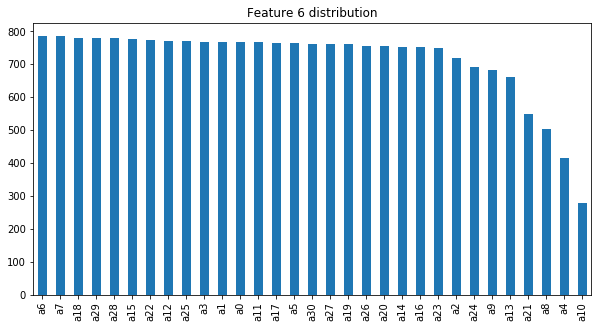

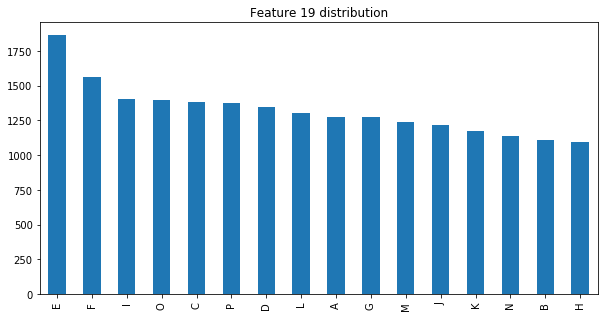

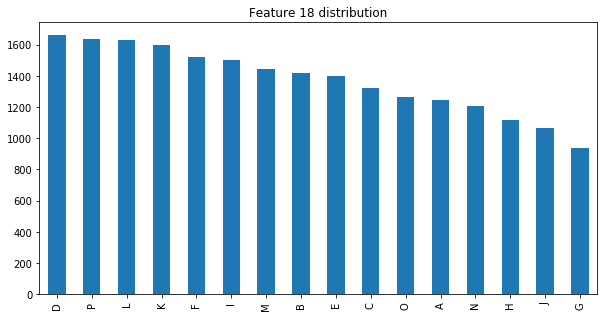

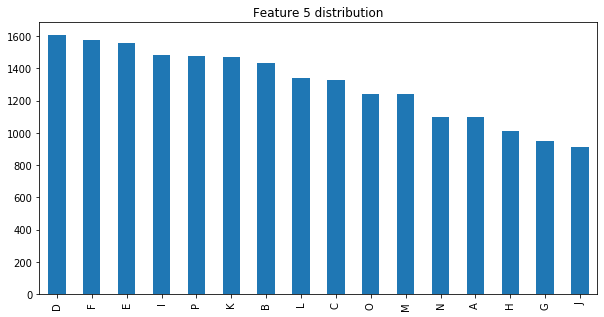

In [89]:
###Catagorical Features Visualization###
'''This visualization allow us to understand how many different categories exist in each Feature
so that if we'll transform them into dummy features we'll know how many new Feature we'll have. 
Moreover if there are Features that are divided into catagories with lower frequencies and few more high frequncies
we can consider combining the lower frequencies into 1 new dummy feature and by that lowering the amoung of new (dummy) features.
Though this isn't the case here as they are mostly even distributed.'''

#Feature_6 distribution:

f6_count = train_df['Feature_6'].value_counts()
plt.figure()
f6_count.plot.bar(figsize=(10, 5))
plt.title("Feature 6 distribution")
plt.show

#Feature_19 distribution:

f19_count = train_df['Feature_19'].value_counts()
plt.figure()
f19_count.plot.bar(figsize=(10, 5))
plt.title("Feature 19 distribution")
plt.show

#Feature_18 distribution:

f18_count = train_df['Feature_18'].value_counts()
plt.figure()
f18_count.plot.bar(figsize=(10, 5))
plt.title("Feature 18 distribution")
plt.show

#Feature_5 distribution:

f5_count = train_df['Feature_5'].value_counts()
plt.figure()
f5_count.plot.bar(figsize=(10, 5))
plt.title("Feature 5 distribution")
plt.show



C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


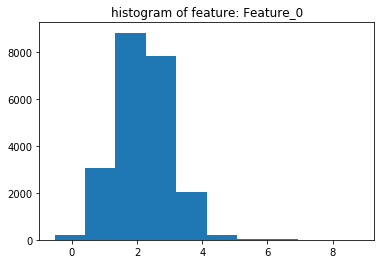

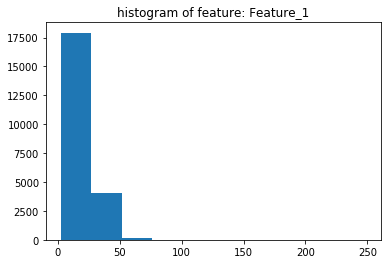

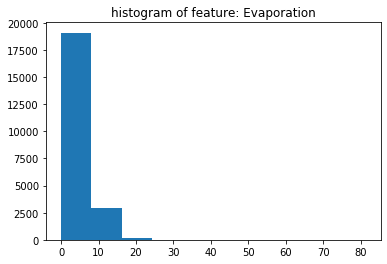

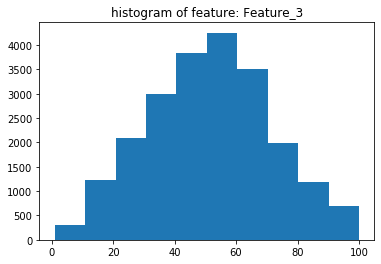

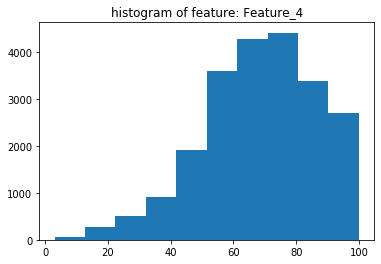

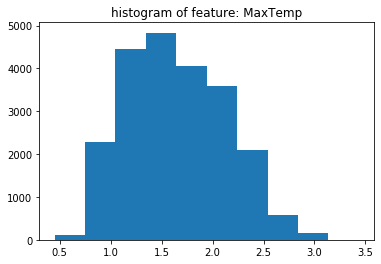

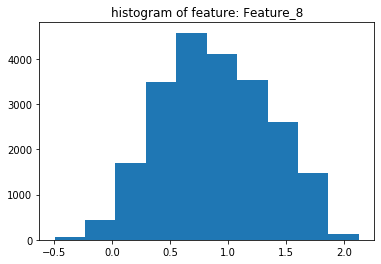

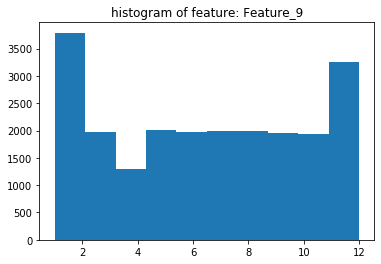

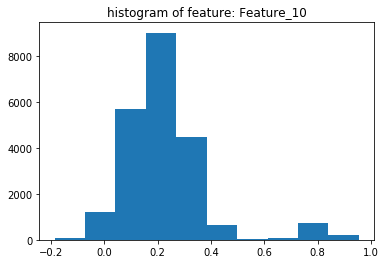

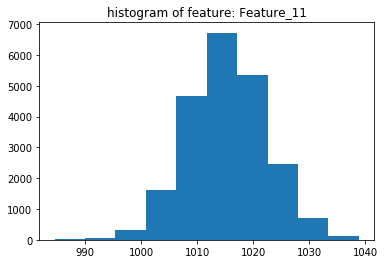

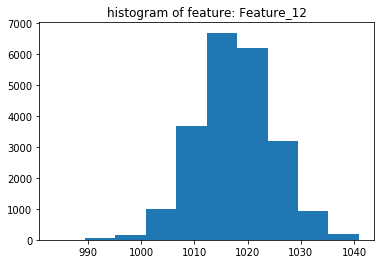

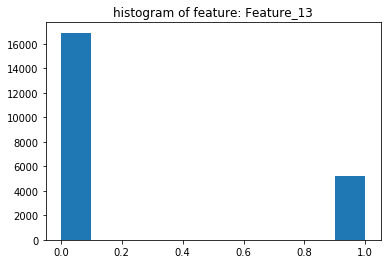

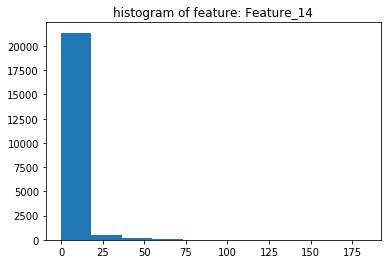

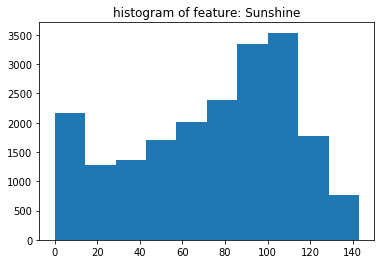

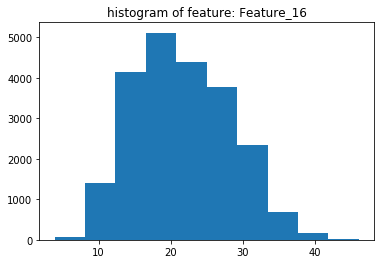

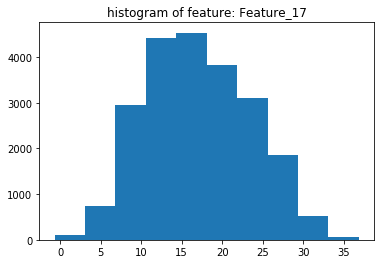

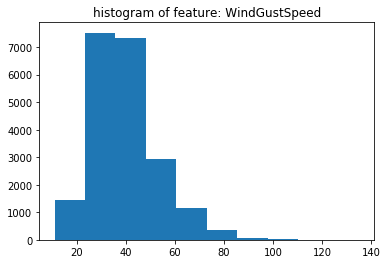

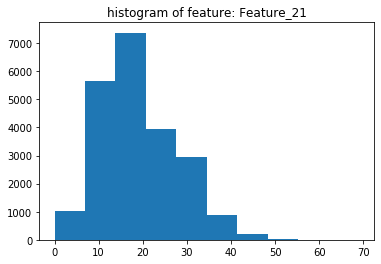

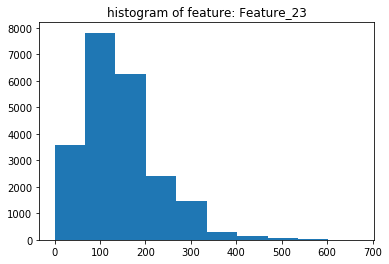

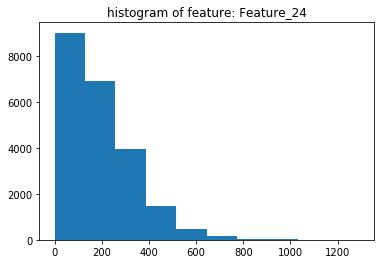

In [90]:
## visulization of the other features (continues features) ##
col_list = ['Feature_0', 'Feature_1', 'Evaporation', 'Feature_3', 'Feature_4', 'MaxTemp', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Sunshine','Feature_16', 'Feature_17', 'WindGustSpeed', 'Feature_21', 'Feature_23', 'Feature_24']
for col in col_list:
    plt.figure()
    plt.hist(train_df[col])
    plt.title(f"histogram of feature: {col}")

In [91]:
train_df.describe() ##before handeling missing data

,Feature_0,Feature_1,Evaporation,Feature_3,Feature_4,MaxTemp,Feature_8,Feature_9,Feature_10,Feature_11,...,Feature_13,Feature_14,Sunshine,Feature_16,Feature_17,WindGustSpeed,Feature_21,Year,Feature_23,Feature_24
count,22161.000000,22161.000000,22161.000000,22102.000000,22057.000000,22154.000000,22143.000000,22161.000000,22161.000000,22055.000000,...,22080.000000,22080.000000,20290.000000,22133.000000,22109.000000,20816.000000,22062.000000,22161.000000,22061.000000,22061.000000
mean,2.188605,19.782469,4.929620,51.547009,68.497982,1.648476,0.888041,6.429358,0.227859,1015.347014,...,0.234330,2.289923,73.685017,21.617133,17.065837,39.995484,19.101577,2010.945264,146.971579,191.782875
std,0.816631,10.772055,3.572644,20.184353,18.231315,0.480275,0.461375,3.381488,0.159533,7.011856,...,0.423589,7.145425,37.866780,6.602743,6.409174,13.150807,8.546933,0.823740,86.609704,148.833906
min,-0.534231,2.776724,0.000000,1.000000,3.000000,0.450000,-0.492857,1.000000,-0.185658,984.500000,...,0.000000,0.000000,0.000000,3.900000,-0.700000,11.000000,0.000000,2010.000000,0.000000,0.021012
25%,1.627396,12.206173,2.400000,37.000000,57.000000,1.271429,0.542857,3.000000,0.136382,1010.600000,...,0.000000,0.000000,45.000000,16.500000,12.100000,31.000000,13.000000,2010.000000,90.000000,76.693088
50%,2.170449,17.848944,4.200000,52.000000,69.000000,1.607143,0.864286,7.000000,0.206442,1015.300000,...,0.000000,0.000000,82.000000,21.000000,16.600000,39.000000,19.000000,2011.000000,130.000000,162.384678
75%,2.718441,25.147043,6.600000,65.000000,82.000000,2.007143,1.242857,9.000000,0.280474,1020.000000,...,0.000000,0.800000,104.000000,26.400000,21.800000,48.000000,24.000000,2012.000000,200.000000,273.166651
max,8.805001,248.339743,81.200000,100.000000,100.000000,3.435714,2.128571,12.000000,0.954180,1038.900000,...,1.000000,183.000000,143.000000,46.100000,36.900000,135.000000,69.000000,2012.000000,670.000000,1289.931375


In [92]:
## checking for missing values precentage per each feature ##
''' If a certain feature has a high precentage of missing values we can consider let this feature go- not the case here.
we shall diffrentiate between handling categorical and continues features. 
for categorical we will replace missing values with the highest frequent
for continues we'll use the mean value. '''

print("Missing values precentage per each feature: ")
print(train_df.isnull().sum().sort_values(ascending=False)/train_df.shape[0]*100)

Missing values precentage per each feature: 
Sunshine         8.442760
Feature_5        6.087270
WindGustSpeed    6.069221
Feature_19       4.602680
Feature_18       0.947611
Feature_12       0.509905
Feature_11       0.478318
Feature_4        0.469293
Feature_23       0.451243
Feature_24       0.451243
Feature_21       0.446731
Feature_14       0.365507
Feature_13       0.365507
Feature_3        0.266233
Feature_17       0.234646
Feature_16       0.126348
Feature_8        0.081224
MaxTemp          0.031587
Feature_10       0.000000
Feature_9        0.000000
Feature_6        0.000000
Year             0.000000
Evaporation      0.000000
Feature_1        0.000000
Feature_0        0.000000
dtype: float64


In [93]:
### Handling missing values ###

#numeric columns (by mean):
train_df.update(train_df.select_dtypes(include='float').fillna(train_df.select_dtypes(include='float').mean().iloc[0]))
test_data.update(test_data.select_dtypes(include='float').fillna(test_data.select_dtypes(include='float').mean().iloc[0]))

#catagorical columns (most frequent):
train_df.update(train_df.select_dtypes(include='object').fillna(train_df.select_dtypes(include='object').mode().iloc[0]))
test_data.update(test_data.select_dtypes(include='object').fillna(test_data.select_dtypes(include='object').mode().iloc[0]))

print("After replacing missing values: ")
print(train_df.isnull().sum().sort_values(ascending=False)/train_df.shape[0]*100) 

After replacing missing values: 
Feature_24       0.0
Feature_11       0.0
Feature_1        0.0
Evaporation      0.0
Feature_3        0.0
Feature_4        0.0
Feature_5        0.0
Feature_6        0.0
MaxTemp          0.0
Feature_8        0.0
Feature_9        0.0
Feature_10       0.0
Feature_12       0.0
Feature_23       0.0
Feature_13       0.0
Feature_14       0.0
Sunshine         0.0
Feature_16       0.0
Feature_17       0.0
Feature_18       0.0
Feature_19       0.0
WindGustSpeed    0.0
Feature_21       0.0
Year             0.0
Feature_0        0.0
dtype: float64


In [94]:
train_df.describe() ##after handeling missing data

,Feature_0,Feature_1,Evaporation,Feature_3,Feature_4,MaxTemp,Feature_8,Feature_9,Feature_10,Feature_11,...,Feature_13,Feature_14,Sunshine,Feature_16,Feature_17,WindGustSpeed,Feature_21,Year,Feature_23,Feature_24
count,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,...,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000,22161.000000
mean,2.188605,19.782469,4.929620,51.415601,68.186797,1.648647,0.889097,6.429358,0.227859,1010.500898,...,0.241473,2.289553,67.648747,21.592585,17.030929,37.700901,19.026022,2010.945264,146.318256,190.927344
std,0.816631,10.772055,3.572644,20.317297,18.744587,0.480295,0.462674,3.381488,0.159533,70.253473,...,0.438954,7.132356,41.327719,6.634566,6.441993,15.618467,8.602088,0.823740,86.957219,149.040427
min,-0.534231,2.776724,0.000000,1.000000,2.188605,0.450000,-0.492857,1.000000,-0.185658,2.188605,...,0.000000,0.000000,0.000000,2.188605,-0.700000,2.188605,0.000000,2010.000000,0.000000,0.021012
25%,1.627396,12.206173,2.400000,37.000000,57.000000,1.271429,0.542857,3.000000,0.136382,1010.500000,...,0.000000,0.000000,31.000000,16.400000,12.100000,30.000000,13.000000,2010.000000,90.000000,75.734053
50%,2.170449,17.848944,4.200000,52.000000,69.000000,1.607143,0.864286,7.000000,0.206442,1015.300000,...,0.000000,0.000000,76.000000,21.000000,16.600000,37.000000,19.000000,2011.000000,130.000000,161.571119
75%,2.718441,25.147043,6.600000,65.000000,82.000000,2.007143,1.242857,9.000000,0.280474,1020.000000,...,0.000000,0.800000,102.000000,26.400000,21.800000,46.000000,24.000000,2012.000000,200.000000,272.542627
max,8.805001,248.339743,81.200000,100.000000,100.000000,3.435714,2.188605,12.000000,0.954180,1038.900000,...,2.188605,183.000000,143.000000,46.100000,36.900000,135.000000,69.000000,2012.000000,670.000000,1289.931375


In [95]:
### Creating dummy features from categorical features ##
def turn_to_dummy(df, cols):
    for col in cols:
        dummy_df = pd.get_dummies(df[col], prefix=col, dummy_na=False)
        df = df.drop(col, 1)
        df = pd.concat([df, dummy_df], axis=1)
    return df

train_df = turn_to_dummy(train_df, ['Feature_5','Feature_6','Feature_18','Feature_19'])
test_data = turn_to_dummy(test_data, ['Feature_5','Feature_6','Feature_18','Feature_19'])

#print(train_df.shape)  ##100 columns, 22161 rows.

                     1st   1st_Val         2nd   2nd_Val          Last  \
Feature_0    Evaporation  0.888534   Feature_1  0.884264     Feature_4   
Feature_1    Evaporation  0.995717   Feature_0  0.884264     Feature_4   
Evaporation    Feature_1  0.995717   Feature_0  0.888534     Feature_4   
Feature_3      Feature_4  0.635885  Feature_13  0.373558      Sunshine   
Feature_4      Feature_3  0.635885  Feature_13  0.342060   Evaporation   
MaxTemp       Feature_16  0.976971  Feature_17  0.886311     Feature_4   
Feature_8     Feature_17  0.896842     MaxTemp  0.740760     Feature_9   
Feature_9     Feature_23  0.062950  Feature_21  0.059086     Feature_8   
Feature_10     Feature_3  0.138893  Feature_13  0.098967      Sunshine   
Feature_11    Feature_12  0.613323  Feature_21  0.062444  Feature_6_a9   

             Last_Val  
Feature_0   -0.480191  
Feature_1   -0.478797  
Evaporation -0.481284  
Feature_3   -0.467719  
Feature_4   -0.481284  
MaxTemp     -0.438011  
Feature_8   -0.23

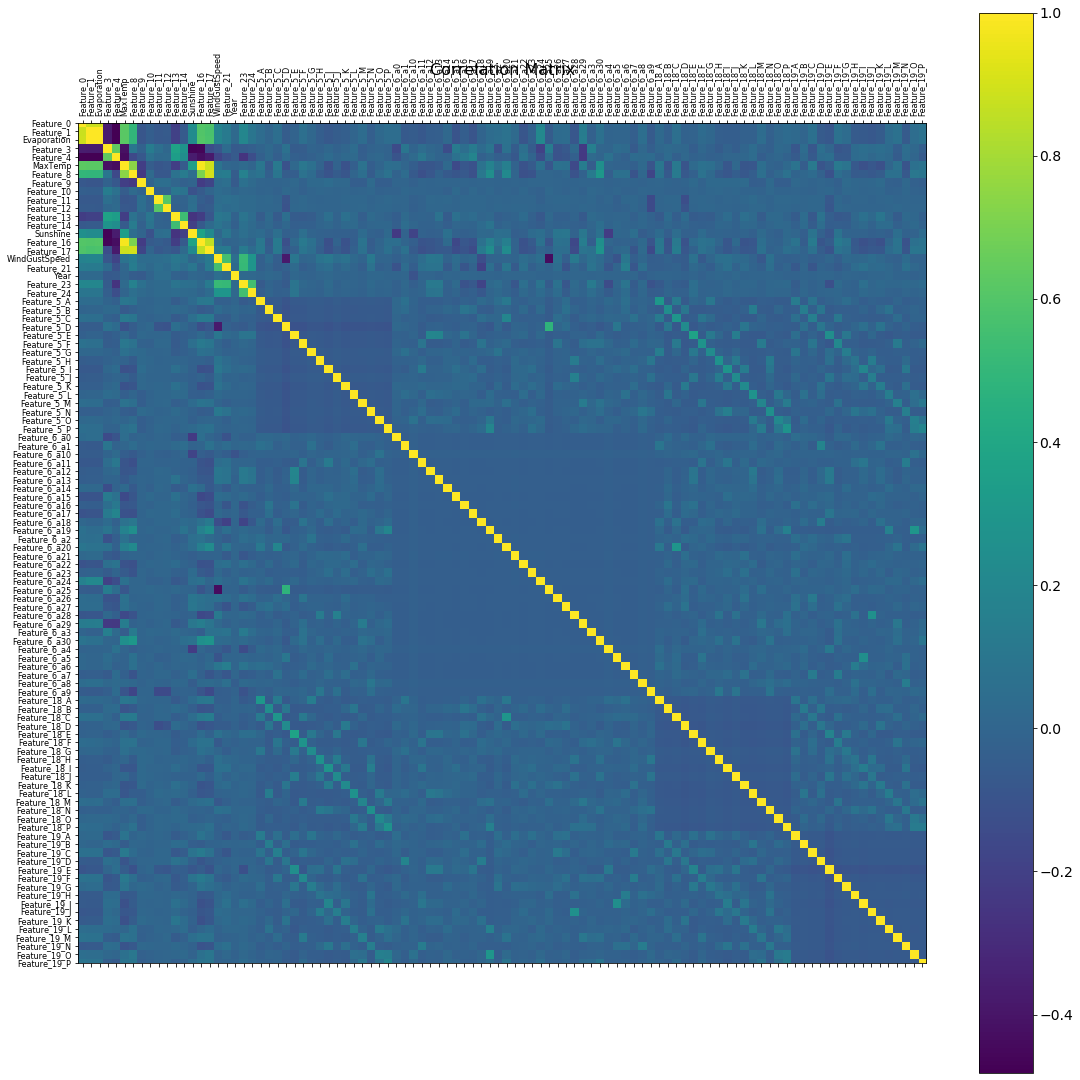

In [96]:
## Correlation Matrix ##
corr_mat = train_df.corr()

f = plt.figure(figsize=(19, 19))
plt.matshow(train_df.corr(), fignum=f.number)
plt.xticks(range(train_df.shape[1]), train_df.columns, fontsize=8, rotation=90)
plt.yticks(range(train_df.shape[1]), train_df.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);


## preparing informative dataframe of the correlation matrix and identifying the correlated features ##
np.fill_diagonal(corr_mat.values, np.nan)

order_top2 = np.argsort(-corr_mat.values, axis=1)[:, :2]
order_bottom = np.argsort(corr_mat.values, axis=1)[:, :1]

result_top2 = pd.DataFrame(corr_mat.columns[order_top2], columns=['1st', '2nd'],index=corr_mat.index)
result_bottom = pd.DataFrame(corr_mat.columns[order_bottom], columns=['Last'],index=corr_mat.index)
result = result_top2.join(result_bottom)
for x in result.columns:
    result[x+"_Val"] = corr_mat.lookup(corr_mat.index, result[x])

result = result[['1st', '1st_Val', '2nd', '2nd_Val', 'Last', 'Last_Val']]
print(result.head(10))
#print("\n\n")
#print(result[result['Last_Val'] <= -0.85])     #empty dataframe
print("\n\n")
print(result[result['1st_Val'] >= 0.85])


Text(0, 0.5, 'Feature_13')

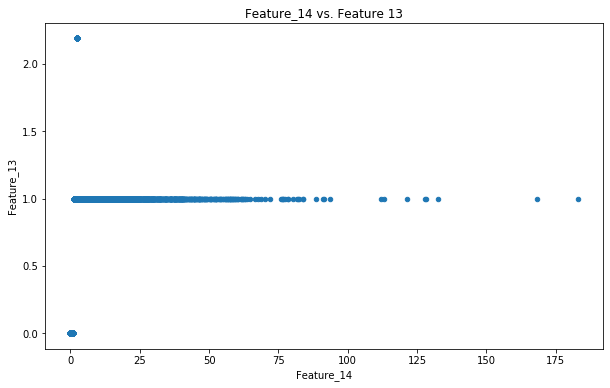

In [97]:
'''From looking at the data i noticed that feature 13 and 14 are most likely related. 
feature 14 is probably the amount of rain while 13 is mainly 1 when the amount of rain is greater than 1 mm else is 0 '''

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
train_df.plot(kind = 'scatter', x = 'Feature_14' ,y = 'Feature_13'  ,ax = ax)
ax.set_title("Feature_14 vs. Feature 13")
ax.set_xlabel("Feature_14")
ax.set_ylabel("Feature_13")




groups of correlated features observed:

group1 = ['MaxTemp', 'Feature_17', 'Feature_16', 'Feature_8']
group2 = ['Feature_11','Feature_12']
group3 = ['Evaporation', 'Feature_1', 'Feature_0']
group4 = ['Feature_13', 'Feature_14']


In [98]:
## standartization of data values ## 
#This step will be crucial for later, when we'll use PCA. The scaling is important so every feature will have am impact that is related to it's variance and not it's scale.
print(test_data.shape)

standard_scaler = StandardScaler()
# We fit our scaler
standard_scaler.fit(train_df)
# We transform our X using the scaler we have just fit.
scaled_df = standard_scaler.transform(train_df)
cols = list(train_df.columns)
train_df = pd.DataFrame(scaled_df, columns = cols) #creating a dataframe from numpy array.

standard_scaler.fit(test_data)
scaled_test = standard_scaler.transform(test_data)
test_data = pd.DataFrame(scaled_test, columns = cols)
#print(train_df)

(7387, 100)


In [99]:
## name change for train ## 

X = train_df 
y = train_labels

In [100]:
## which of the feature best correlate with the label from each group of correlated variables:
'''The Feature that best correlate with the labels are the one we'll continue with from each group.'''

vars1 = ['MaxTemp', 'Feature_17', 'Feature_16', 'Feature_8']
vars2 = ['Feature_11','Feature_12']
vars3 = ['Evaporation', 'Feature_1', 'Feature_0']
vars4 = ['Feature_13', 'Feature_14']
absCorrWithDep1 = []
absCorrWithDep2 = []
absCorrWithDep3 = []
absCorrWithDep4 = []
for var in vars1:
    absCorrWithDep1.append(abs(y.corr(X[var])))
for var in vars2:
    absCorrWithDep2.append(abs(y.corr(X[var])))
for var in vars3:
    absCorrWithDep3.append(abs(y.corr(X[var])))
for var in vars4:
    absCorrWithDep4.append(abs(y.corr(X[var])))
    
print(absCorrWithDep1)
print(f"the Feature that best correlate with the label is {vars1[np.argmax(absCorrWithDep1)]}")
print(absCorrWithDep2)
print(f"the Feature that best correlate with the label is {vars2[np.argmax(absCorrWithDep2)]}")
print(absCorrWithDep3)
print(f"the Feature that best correlate with the label is {vars3[np.argmax(absCorrWithDep3)]}")
print(absCorrWithDep4)
print(f"the Feature that best correlate with the label is {vars4[np.argmax(absCorrWithDep4)]}")


[0.12309773813857137, 0.009543004627811835, 0.16081974336330462, 0.12206128198510324]
the Feature that best correlate with the label is Feature_16
[0.02189650580099604, 0.020867579843005093]
the Feature that best correlate with the label is Feature_11
[0.10409291114657698, 0.10339795055394249, 0.10172697338863179]
the Feature that best correlate with the label is Evaporation
[0.3086547452880211, 0.2570644326069705]
the Feature that best correlate with the label is Feature_13


#clustering of the features 
from sklearn.cluster import FeatureAgglomeration
varclus = FeatureAgglomeration(n_clusters = 15)
varclus.fit(X)
train_varclus = varclus.transform(X)

train_varclus.shape

In [101]:
## dropping the irelevent features.
X.drop('Feature_1', axis = 1, inplace = True)
X.drop('MaxTemp', axis = 1, inplace = True)
X.drop('Feature_12', axis = 1, inplace = True)
X.drop('Feature_0', axis = 1, inplace = True)
X.drop('Feature_17', axis = 1, inplace = True)
X.drop('Feature_8', axis = 1, inplace = True)
X.drop('Feature_14', axis = 1, inplace = True)

test_data.drop('Feature_1', axis = 1, inplace = True)
test_data.drop('MaxTemp', axis = 1, inplace = True)
test_data.drop('Feature_12', axis = 1, inplace = True)
test_data.drop('Feature_0', axis = 1, inplace = True)
test_data.drop('Feature_17', axis = 1, inplace = True)
test_data.drop('Feature_8', axis = 1, inplace = True)
test_data.drop('Feature_14', axis = 1, inplace = True)



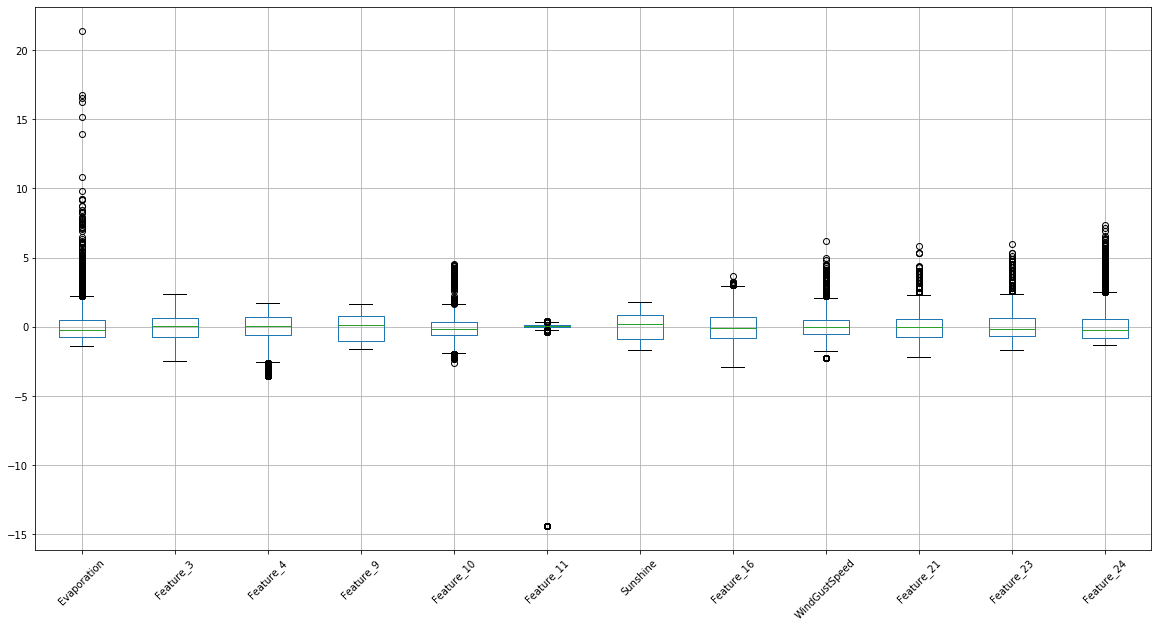

In [102]:
#Box plot of the continues Features- before dropping outliers:
col_list = ['Evaporation', 'Feature_3', 'Feature_4','Feature_9', 'Feature_10', 'Feature_11', 'Sunshine','Feature_16', 'WindGustSpeed', 'Feature_21', 'Feature_23', 'Feature_24']
X.boxplot(column=col_list, figsize=(20, 10), rot=45)
plt.show()

I tried removing the ouliers using the following code, but it lowered the model performance. Therfore, I decided to handle only rows that has multiple (more than 5) outliers instead.

In [103]:
'''
col_list = ['Feature_3', 'Feature_4' , 'Feature_9', 'Feature_11', 'Sunshine','Feature_16' , 'WindGustSpeed', 'Feature_21', 'Feature_23', 'Feature_24']
for col in col_list:
    q_low = X[col].quantile(0.0001)
    q_hi  = X[col].quantile(0.9999)
    y = y[(X[col] < q_hi) & (X[col] > q_low)]
    X = X[(X[col] < q_hi) & (X[col] > q_low)]
    
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

'''

"\ncol_list = ['Feature_3', 'Feature_4' , 'Feature_9', 'Feature_11', 'Sunshine','Feature_16' , 'WindGustSpeed', 'Feature_21', 'Feature_23', 'Feature_24']\nfor col in col_list:\n    q_low = X[col].quantile(0.0001)\n    q_hi  = X[col].quantile(0.9999)\n    y = y[(X[col] < q_hi) & (X[col] > q_low)]\n    X = X[(X[col] < q_hi) & (X[col] > q_low)]\n    \nX = X.reset_index(drop=True)\ny = y.reset_index(drop=True)\n\n"

In [104]:
def find_outlier(df, col_list):
    d_outlier = {}
    for x in col_list:
        q1 = np.percentile(df[x],25)
        q3 = np.percentile(df[x],75)
        iqr = q3-q1
        floor = q1 - (1.5 * iqr)
        ceiling = q3 + (1.5 * iqr)
        outlier_indices = list(df[x].index[(df[x] < floor) | (df[x] > ceiling)])
        d_outlier[x] = outlier_indices
    return d_outlier

col_list = ['Evaporation', 'Feature_3', 'Feature_4', 'Feature_9', 'Feature_10', 'Feature_11', 'Sunshine','Feature_16', 'WindGustSpeed', 'Feature_21', 'Feature_23', 'Feature_24']
outlier_dict = find_outlier(X, col_list)
outlier_freq = {}
for col in col_list:
    if len(outlier_dict[col]) > 0:
        for ind in outlier_dict[col]:
            outlier_freq[ind] = outlier_freq.get(ind, 0) + 1
sorted_outlier_ind = sorted(outlier_freq, key=outlier_freq.get, reverse=True)

ouliers_to_del = []
#print(f"The highest frequency is {outlier_freq[sorted_outlier_ind[0]]} of ind {sorted_outlier_ind[0]}")
for i in range(40):
    print(f"The {i+1}'th highest frequency is {outlier_freq[sorted_outlier_ind[i]]} of ind {sorted_outlier_ind[i]}")
    if outlier_freq[sorted_outlier_ind[i]] >= 5:
        ouliers_to_del.append(sorted_outlier_ind[i])

ouliers_to_del.sort()
X.drop(ouliers_to_del)
y.drop(ouliers_to_del)

The 1'th highest frequency is 6 of ind 17119
The 2'th highest frequency is 6 of ind 8234
The 3'th highest frequency is 5 of ind 2525
The 4'th highest frequency is 5 of ind 6813
The 5'th highest frequency is 5 of ind 14255
The 6'th highest frequency is 5 of ind 20432
The 7'th highest frequency is 5 of ind 20580
The 8'th highest frequency is 5 of ind 4913
The 9'th highest frequency is 5 of ind 555
The 10'th highest frequency is 5 of ind 1726
The 11'th highest frequency is 5 of ind 4941
The 12'th highest frequency is 5 of ind 8686
The 13'th highest frequency is 5 of ind 9200
The 14'th highest frequency is 5 of ind 9496
The 15'th highest frequency is 5 of ind 9615
The 16'th highest frequency is 5 of ind 17631
The 17'th highest frequency is 5 of ind 17680
The 18'th highest frequency is 4 of ind 1374
The 19'th highest frequency is 4 of ind 2436
The 20'th highest frequency is 4 of ind 5422
The 21'th highest frequency is 4 of ind 6733
The 22'th highest frequency is 4 of ind 7930
The 23'th high

0        1
1        0
2        0
3        0
4        0
        ..
22156    0
22157    0
22158    1
22159    1
22160    0
Name: label, Length: 22144, dtype: int64

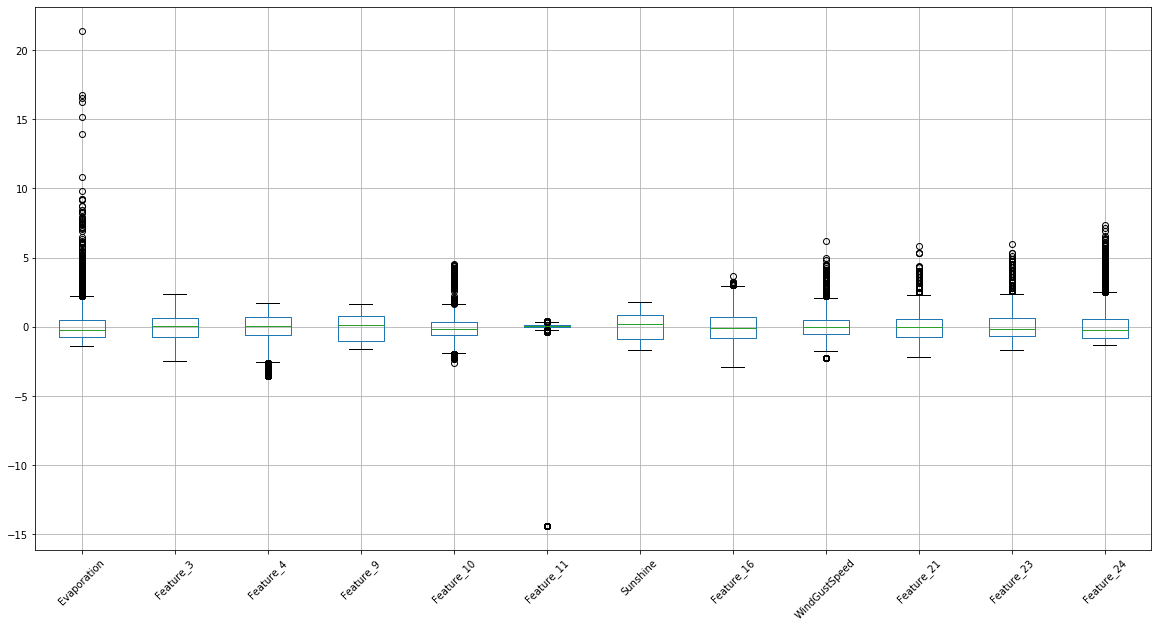

In [105]:
# Box plot of the continues Features- after removing outliers
col_list = ['Evaporation', 'Feature_3', 'Feature_4','Feature_9', 'Feature_10', 'Feature_11', 'Sunshine','Feature_16', 'WindGustSpeed', 'Feature_21', 'Feature_23', 'Feature_24']
X.boxplot(column=col_list, figsize=(20, 10), rot=45)
plt.show()

In [106]:
## creating new feature ##
#first step- measuring which features best correlate with the label:
cor_list = []
for var in col_list:
    temp = abs(y.corr(X[var]))
    cor_list.append(temp)
    
label_cor = np.array(cor_list) 
ind_vec = label_cor.argsort()[::-1]
max_label = col_list[ind_vec[0]]
sec_max_label = col_list[ind_vec[1]]

print(cor_list)    
'''first_max = col_list[0]
if label_cor[1] > label_cor[0]
    second_max = first_max
    first_max = col_list[1]
else:
    second_max = col_list[1]
    
for i in range(len(col_list)):
    if i>2:
        temp = label_cor[i]
        if temp > first_max:
            second_max = first_max
            first_max = temp
        else if temp > second_max:
            second_max = temp
'''        
print(f"The most cor feature is {max_label}, the second cor feature {sec_max_label}")

X['sunshine_mul_feature3']=X['Sunshine']*X['Feature_3']
test_data['sunshine_mul_feature3']=test_data['Sunshine']*test_data['Feature_3']


[0.10409291114657698, 0.45646482282363227, 0.2477271300192606, 0.012285220344784945, 0.3063324273618401, 0.02189650580099604, 0.3598672279187108, 0.16081974336330462, 0.17444279288245187, 0.08638332060970824, 0.08671772096821379, 0.048148946552246864]
The most cor feature is Feature_3, the second cor feature Sunshine


In [107]:
## Features selection ##
'''After dropping the correlated features found, we still need to further reduce the dimensions.
high dimentionality can cause overfitting and has a high computational cost.
if we want to know wheter we still have high dimensionality- we can check if our model is over fit by comparing it's performance on the data vs the validation set, this can be a sign.'''

select = SelectKBest(k=25)
selected_features = select.fit(X, y)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]
X_train_selected = X[colnames_selected]
test_data_selected = test_data[colnames_selected] 
for x in colnames_selected:
    print(x)

Evaporation
Feature_3
Feature_4
Feature_10
Feature_13
Sunshine
Feature_16
WindGustSpeed
Feature_21
Feature_23
Feature_24
Feature_5_N
Feature_5_P
Feature_6_a0
Feature_6_a14
Feature_6_a15
Feature_6_a17
Feature_6_a24
Feature_6_a29
Feature_6_a3
Feature_18_M
Feature_19_F
Feature_19_J
Feature_19_P
sunshine_mul_feature3


In [108]:
# in order to further reduce X dimensions we'll use PCA.
# initialize PCA
pca = PCA(n_components=15)
# Fit the model with the data
pca.fit(X_train_selected)
# apply the PCA on the data (or on new data)
X = pca.transform(X_train_selected)
test_data = pca.transform(test_data_selected)

print("Percentage of variance explained by the selected components")
print(sum(pca.explained_variance_ratio_))


print(X.shape)



Percentage of variance explained by the selected components
0.7823379591806866
(22161, 15)


# Part 3: Modelling

I chose to search for the models hyper-parameters using a gready technique, after grid-search yeilded poorer results.

In [24]:
'''## KNN hyper- parameters:
#Create Hyperparameter Search Space
n_neighbors = [1,2,5,7,10,15,20,30,40,50,100]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [5,10,15,20,25,30,35,40,45,50,100]
p = [1,2]

n_n_res = []
w_res = []
al_res = []
leaf_res = []
some_p_res = []
auc_res = []


kf = KFold(n_splits=6, random_state=None, shuffle=True)
x_axis = np.linspace(0, 1, 50, endpoint=True)
y_interp = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    auc_list = []
    for n_n in n_neighbors:
        clf = KNeighborsClassifier(n_neighbors=n_n)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    n_n = n_neighbors[np.argmax(auc_list)]
    n_n_res.append(n_n)

    auc_list = []
    for w in weights:
        clf = KNeighborsClassifier(weights=w, n_neighbors=n_n)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    w = weights[np.argmax(auc_list)]
    w_res.append(w)
    
    auc_list = []
    for al in algorithm:
        clf = KNeighborsClassifier(weights=w, n_neighbors=n_n, algorithm=al)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    al = algorithm[np.argmax(auc_list)]
    al_res.append(al)

    auc_list = []
    for leaf in leaf_size:
        clf = KNeighborsClassifier(weights=w, n_neighbors=n_n, algorithm=al, leaf_size=leaf)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    leaf = leaf_size[np.argmax(auc_list)]
    leaf_res.append(leaf)
    
    auc_list = []
    for some_p in p:
        clf = KNeighborsClassifier(weights=w, n_neighbors=n_n, algorithm=al, leaf_size=leaf, p=some_p)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    some_p = p[np.argmax(auc_list)]
    some_p_res.append(some_p)

    max_clf = KNeighborsClassifier(weights=w, n_neighbors=n_n, algorithm=al, leaf_size=leaf, p=some_p)
    max_clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    auc_res.append(auc(fpr, tpr))
    
    
n_n = n_n_res[np.argmax(auc_res)]
w = w_res[np.argmax(auc_res)]
al = al_res[np.argmax(auc_res)]
leaf = leaf_res[np.argmax(auc_res)]
some_p = some_p_res[np.argmax(auc_res)]

##Chosen hyperparameters:
print(f"n_neighbors chosen is {n_n}")
print(f"weights chosen is {w}")
print(f"algorithm chosen is {al}")
print(f"leaf_size chosen is {leaf}")
print(f"The p chosen is {some_p}")
'''
#output- n_neighbors chosen is 100, weights chosen is distance, algorithm chosen is auto, leaf_size chosen is 5, The p chosen is 1.

n_neighbors chosen is 100
weights chosen is distance
algorithm chosen is auto
leaf_size chosen is 5
The p chosen is 1


a trial for more complex KNN hyper-parameters tuning:
#Create Hyperparameter Search Space
n_neighbors = [1,2,5,7,10,15,20,30,40,50,100]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [5,10,15,20,25,30,35,40,45,50,100]
p = [1,2]
 
max_knn_clf = KNeighborsClassifier()
max_knn_clf.fit(X_train, y_train)
y_prob = max_knn_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
max_auc_score = auc(fpr, tpr)
for n_n in n_neighbors:
     for w in weights:
            for al in algorithm:
                for leaf in leaf_size:
                    for some_p in p:
                        clf = KNeighborsClassifier(weights=w, n_neighbors=n_n, algorithm=al, leaf_size=leaf, p=some_p)
                        clf.fit(X_train, y_train)
                        y_prob = clf.predict_proba(X_test)
                        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
                        auc_score = auc(fpr, tpr)
                        if auc_score > max_auc_score:
                            max_auc_score = auc_score
                            max_knn_clf = clf
                            max_p = some_p
                            max_leaf = leaf
                            max_al = al
                            max_w = w
                            max_n_n = n_n

##Chosen hyperparameters:
print(f"n_neighbors chosen is {max_n_n}")
print(f"weights chosen is {max_w}")
print(f"algorithm chosen is {max_al}")
print(f"leaf_size chosen is {max_leaf}")
print(f"The p chosen is {max_p}")

##The max AUC
print(f"The AUC is : {max_auc_score}")

In [25]:
#A function we wrote in our homework that uses Kfolds and print out the roc curve of each of the k iteratrions (mean included) and the mean AUC
def KfoldPlot(X, y, clf, k):
    kf = KFold(n_splits=k, random_state=None, shuffle=True)
    i = 0
    x_axis = np.linspace(0, 1, 50, endpoint=True)
    y_interp = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        y_interp.append(np.interp(x_axis, fpr, tpr))
        plt.plot(fpr, tpr, label=f"fold number {i+1}", alpha=0.7)
        i += 1
    #calculate mean ROC:
    mean_y = np.mean(y_interp, axis=0)
    #plotting the mean ROC:
    plt.plot(x_axis, mean_y, color="red", linestyle="--", label="mean ROC") 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve- of {k} folds")
    plt.legend()
    plt.show()
    #Calculate AUC:
    print('AUC: %.2f' % auc(x_axis, mean_y))

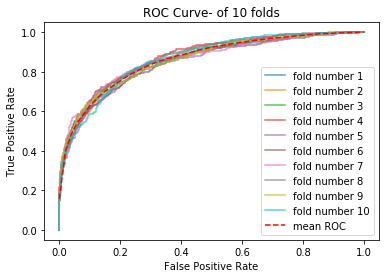

AUC: 0.86


In [26]:
#knnclf:
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=100, algorithm='auto', leaf_size=5, p=1)
KfoldPlot(X, y, max_clf, 10)


overall KNN AUC achived was 0.86

Next classifier is- Logistic regression

In [27]:
'''## Logistic regression parameters:
#Create Hyperparameter Search Space
powers = range(-10,0)

max_iter = [50, 70, 100, 150, 200, 250]
solver = ['newton-cg' ,'lbfgs', 'liblinear', 'saga', 'sag']
Cs = [10**p for p in powers]
penalty = ['l1', 'l2']

max_iter_res = []
solver_res = []
Cs_res = []
penalty_res = []
auc_res = []

kf = KFold(n_splits=6, random_state=None, shuffle=True)
x_axis = np.linspace(0, 1, 50, endpoint=True)
y_interp = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    auc_list = []
    for it in max_iter:
        clf = LogisticRegression(max_iter=it)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    it = max_iter[np.argmax(auc_list)]
    max_iter_res.append(it)

    auc_list = []
    for sol in solver:
        clf = LogisticRegression(max_iter=it, solver=sol)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    sol = solver[np.argmax(auc_list)]
    solver_res.append(sol)
    
    if (sol == 'lbfgs') or (sol == 'sag') or (sol == 'newton-cg'):
        p = 'l2'
        penalty_res.append(p)
    else:
        auc_list = []
        for p in penalty:
            clf = LogisticRegression(max_iter=it, solver=sol, penalty=p)
            clf.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
            auc_score = auc(fpr, tpr)
            auc_list.append(auc_score)
        p = penalty[np.argmax(auc_list)]
        penalty_res.append(p)
        
    auc_list = []
    for c in Cs:
        clf = LogisticRegression(max_iter=it, solver=sol, C=c, penalty=p)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    c = Cs[np.argmax(auc_list)]
    Cs_res.append(c)
 
    logreg_clf = LogisticRegression(max_iter=it, solver=sol, C=c, penalty=p)
    logreg_clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    auc_res.append(auc(fpr, tpr))

it = max_iter_res[np.argmax(auc_res)]
sol = solver_res[np.argmax(auc_res)]
c = Cs_res[np.argmax(auc_res)]
p = penalty_res[np.argmax(auc_res)]
##Chosen hyperparameters:
print(f"max_iter chosen is {it}")
print(f"solver chosen is {sol}")
print(f"penalty chosen is {p}")
print(f"The C chosen is {c}")

'''

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

max_iter chosen is 50
solver chosen is newton-cg
penalty chosen is l2
The C chosen is 0.001


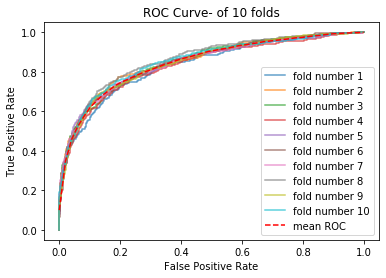

AUC: 0.85


In [28]:
logreg_clf = LogisticRegression(max_iter=50, solver='newton-cg', C=0.001, penalty='l2') # the hyper-parameters chosed
KfoldPlot(X, y, logreg_clf, 10)

overall: 
KNN AUC achived was 0.86
Logistic regression AUC achived was 0.85
Next classifier is- MLP

In [29]:
'''
##ANN -parameters:
powers = range(-10,0)


hidden_layer_sizes = [50, 70, 100, 150]
max_iter = [50, 100, 150, 200, 250]
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [10**p for p in powers]
learning_rate = ['constan', 'invscaling', 'adaptive']
learning_rate_init = [0.01, 0.001]

hls_res = []
it_res = []
act_res = []
sol_res = []
a_res = []
l_r_res = []
l_r_i_res = []
auc_res = []


kf = KFold(n_splits=6, random_state=None, shuffle=True)
x_axis = np.linspace(0, 1, 50, endpoint=True)
y_interp = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    auc_list = []
    for hls in hidden_layer_sizes:
        clf = MLPClassifier(hidden_layer_sizes=hls)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    hls = hidden_layer_sizes[np.argmax(auc_list)]
    hls_res.append(hls)

    auc_list = []
    for sol in solver:
        clf = MLPClassifier(solver=sol, hidden_layer_sizes=hls)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    sol = solver[np.argmax(auc_list)]
    sol_res.append(sol)

    auc_list = []
    for it in max_iter:
        clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    it = max_iter[np.argmax(auc_list)]
    it_res.append(it)

    auc_list = []
    for act in activation:
        clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls, activation=act)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    act = activation[np.argmax(auc_list)]
    act_res.append(act)

    auc_list = []
    for a in alpha:
        clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls, activation=act, alpha=a)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    a = alpha[np.argmax(auc_list)]
    a_res.append(a)

    if solver=='sgd':
        auc_list = []
        for l_r in learning_rate:
            clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls, activation=act, learning_rate=l_r, alpha=a)
            clf.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
            auc_score = auc(fpr, tpr)
            auc_list.append(auc_score)
        l_r = learning_rate[np.argmax(auc_list)]
        l_r_res.append(l_r)
        auc_list = []
        for l_r_i in learning_rate_init:
            clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls, activation=act, learning_rate=l_r, learning_rate_init=l_r_i, alpha=a)
            clf.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
            auc_score = auc(fpr, tpr)
            auc_list.append(auc_score)
        l_r_i = learning_rate[np.argmax(auc_list)]
        l_r_i_res.append(l_r_i)
        ann_clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls, activation=act, learning_rate=l_r, learning_rate_init=l_r_i)
    else:
        l_r_res.append(0)
        l_r_i_res.append(0)
        ann_clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls, activation=act, alpha=a)
    
    ann_clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    auc_res.append(auc(fpr, tpr))
    '''


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

In [30]:
'''
hls = hls_res[np.argmax(auc_res)]
it = it_res[np.argmax(auc_res)]
act = act_res[np.argmax(auc_res)]
sol = sol_res[np.argmax(auc_res)]
a = a_res[np.argmax(auc_res)]
if 'sgd' in sol_res:
    l_r = l_r_res[np.argmax(auc_res)]
    l_r_i = l_r_i_res[np.argmax(auc_res)]
    print(f"The learning_rate chosen is {l_r}")
    print(f"The learning_rate_init chosen is {L_r_i}")
    ann_clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls, activation=act, learning_rate=l_r, learning_rate_init=l_r_i)
else:
    ann_clf = MLPClassifier(max_iter=it, solver=sol, hidden_layer_sizes=hls, activation=act, alpha=a)

##Chosen hyperparameters:
print(f"hidden_layer_sizes chosen is {hls}")
print(f"max_iter chosen is {it}")
print(f"activation chosen is {act}")
print(f"The solver chosen is {sol}")
print(f"The alpha chosen is {a}")

'''

hidden_layer_sizes chosen is 50
max_iter chosen is 250
activation chosen is logistic
The solver chosen is adam
The alpha chosen is 1e-07


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

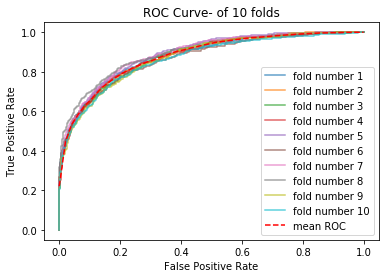

AUC: 0.88


In [31]:
ann_clf = MLPClassifier(max_iter=250, solver='adam', hidden_layer_sizes=50, activation='logistic', alpha=1e-07)
KfoldPlot(X, y, ann_clf, 10)

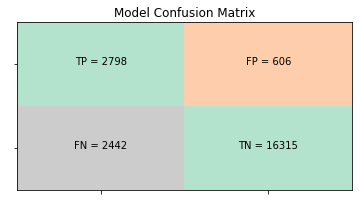

In [32]:
#get training accuracy:
ft_acc = ann_clf.score(X, y)

X_pred = ann_clf.predict(X)

#Plotting the train confusion matrix:
confusion_mat = confusion_matrix(y, X_pred)

plt.imshow(confusion_mat, cmap='Pastel2')
plt.yticks([0.25,0.75],[" "," "])
plt.xticks([0,1],[" "," "])
plt.ylim(0,1)
plt.text(0, 1, f"FN = {confusion_mat[1, 0]}",
                           ha="center", position=(0,0.25), color="k")
plt.text(0, 0, f"FP = {confusion_mat[0, 1]}",
                           ha="center", position=(1,0.75), color="k")
plt.text(1, 0, f"TP = {confusion_mat[1, 1]}",
                           ha="center", position=(0,0.75), color="k")
plt.text(1, 1, f"TN = {confusion_mat[0, 0]}",
                           ha="center", position=(1,0.25), color="k")
plt.title("Model Confusion Matrix")
plt.show()

The confuision Matrix calculates the amount of successful/unsuccessful prediction our model had.
TP- when the true label was 1 and the model predicted 1
FP- when the true label was 0 and the model predicted 1
FN- when the true label was 1 and the model predicted 0
TN- when the true label was 0 and the model predicted 0
from these values we can calcaulate the precision, sesitivity and specificity of the model' and evaluate it. 

overall: 
KNN AUC achived was 0.86
Logistic regression AUC achived was 0.85
ANN AUC achived was 0.88
Next classifier is- SVM

the following part is an attemp to use a SVM model:

from sklearn.svm import SVC
svm_clf = SVC(C=1.0, kernel='rbf', degree=3, gamma=0.01, probability=True)

KfoldPlot(X, y, svm_clf, 10)

powers = range(-2,4)

Gs = [10**p for p in powers]
Kernel = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = [0.01, 0.1, 1, 10, 10, 50, 100, 500, 1000]


auc_list = []
for k in Kernel:
    clf = SVC(kernel = k, probability=True)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    auc_score = auc(fpr, tpr)
    auc_list.append(auc_score)
k = Kernel[np.argmax(auc_list)]
print(f"The kernel chosen is {k}")


auc_list = []
for g in Gs:
    clf = SVC(kernel = k, gamma=g, probability=True)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    auc_score = auc(fpr, tpr)
    auc_list.append(auc_score)
g = Gs[np.argmax(auc_list)]
print(f"The gamma chosen is {g}")


auc_list = []
for c in Cs:
    clf = SVC(kernel = k, gamma=g, C=c, probability=True)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    auc_score = auc(fpr, tpr)
    auc_list.append(auc_score)
c = Cs[np.argmax(auc_list)]
print(f"The C chosen is {c}")


svm_clf = SVC(kernel = k, gamma=g, C=c, probability=True)
svm_clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
print(f"The AUC is : {auc(fpr, tpr)}")

KfoldPlot(X, y, svm_clf, 10)

overall: 
KNN AUC achived was 0.86
Logistic regression AUC achived was 0.85
ANN AUC achived was 0.88
SVM AUC achived was 0.84
Next classifier is- Random forest

In [34]:
'''
## Random Forest
# criterion
criterion = ['gini', 'entropy']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 40)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 33)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Random state-
random_state = [1, 3, 7, 10, 17]


# Number of trees in random forest
n_e_res = []
m_f_res = []
m_d_res = []
m_s_s_res = []
m_s_l_res = []
b_s_res = []
r_s_res = []
auc_res = []
c_res = []

kf = KFold(n_splits=6, random_state=None, shuffle=True)
x_axis = np.linspace(0, 1, 50, endpoint=True)
y_interp = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    auc_list = []
    for n_e in n_estimators:
        clf = RandomForestClassifier(n_estimators=n_e)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    n_e = n_estimators[np.argmax(auc_list)]
    n_e_res.append(n_e)

    auc_list = []
    for m_f in max_features:
        clf = RandomForestClassifier(n_estimators=n_e, max_features=m_f)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    m_f = max_features[np.argmax(auc_list)]
    m_f_res.append(m_f)

    auc_list = []
    for m_d in max_depth:
        clf = RandomForestClassifier(n_estimators=n_e, max_features=m_f, max_depth=m_d)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    m_d = max_depth[np.argmax(auc_list)]
    m_d_res.append(m_d)


    auc_list = []
    for m_s_s in min_samples_split:
        clf = RandomForestClassifier(n_estimators=n_e, max_features=m_f, max_depth=m_d, min_samples_split=m_s_s)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    m_s_s = min_samples_split[np.argmax(auc_list)]
    m_s_s_res.append(m_s_s)


    auc_list = []
    for m_s_l in min_samples_leaf:
        clf = RandomForestClassifier(n_estimators=n_e, max_features=m_f, max_depth=m_d, min_samples_split=m_s_s, min_samples_leaf=m_s_l)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    m_s_l = min_samples_leaf[np.argmax(auc_list)]
    m_s_l_res.append(m_s_l)

    auc_list = []
    for b_s in bootstrap:
        clf = RandomForestClassifier(n_estimators=n_e, max_features=m_f, max_depth=m_d, min_samples_split=m_s_s, min_samples_leaf=m_s_l, bootstrap=b_s)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    b_s = bootstrap[np.argmax(auc_list)]
    b_s_res.append(b_s)

    auc_list = []
    for r_s in random_state:
        clf = RandomForestClassifier(n_estimators=n_e, max_features=m_f, max_depth=m_d, min_samples_split=m_s_s, min_samples_leaf=m_s_l, bootstrap=b_s, random_state=r_s)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    r_s = random_state[np.argmax(auc_list)]
    r_s_res.append(r_s)

    auc_list = []
    for c in criterion:
        clf = RandomForestClassifier(criterion=c, n_estimators=n_e, max_features=m_f, max_depth=m_d, min_samples_split=m_s_s, min_samples_leaf=m_s_l, bootstrap=b_s, random_state=r_s)
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        auc_list.append(auc_score)
    c = criterion[np.argmax(auc_list)]
    c_res.append(c)

    rf_clf = RandomForestClassifier(criterion=c, n_estimators=n_e, max_features=m_f, max_depth=m_d, min_samples_split=m_s_s, min_samples_leaf=m_s_l, bootstrap=b_s, random_state=r_s)
    rf_clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    auc_res.append(auc(fpr, tpr))
    

c = c_res[np.argmax(auc_res)]
n_e = n_e_res[np.argmax(auc_res)]
m_f = m_f_res[np.argmax(auc_res)]
m_d = m_d_res[np.argmax(auc_res)]
m_s_s = m_s_s_res[np.argmax(auc_res)]
m_s_l = m_s_l_res[np.argmax(auc_res)]
b_s = b_s_res[np.argmax(auc_res)]
r_s = r_s_res[np.argmax(auc_res)]
print(f"The criterion chosen is {c}")
print(f"The n_estimators chosen is {n_e}")
print(f"The max_features chosen is {m_f}")
print(f"The max_depth chosen is {m_d}")
print(f"The min_samples_split chosen is {m_s_s}")
print(f"The min_samples_leaf chosen is {m_s_l}")
print(f"The bootstrap chosen is {b_s}")
print(f"The random_state chosen is {r_s}")
'''



The criterion chosen is entropy
The n_estimators chosen is 161
The max_features chosen is log2
The max_depth chosen is 13
The min_samples_split chosen is 10
The min_samples_leaf chosen is 10
The bootstrap chosen is False
The random_state chosen is 1


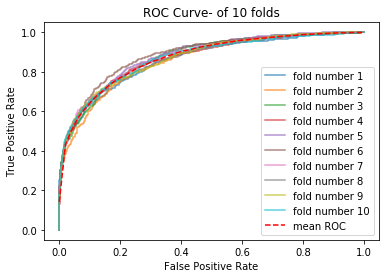

AUC: 0.87


In [35]:
rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=161, max_features='log2', max_depth=13, min_samples_split=10, min_samples_leaf=10, bootstrap=False, random_state=1)
KfoldPlot(X, y, rf_clf, 10)

overall: 
KNN AUC achived was 0.86
Logistic regression AUC achived was 0.85
ANN AUC achived was 0.88
random forest AUC achived was 0.87


from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
KfoldPlot(X, y, nb_clf, 10)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)

In [110]:
#Logistic Regression-
lg_clf = LogisticRegression(max_iter=50, solver='sag', C=0.001, penalty='l2')
lg_clf.fit(X_train, y_train)
y_prob = lg_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
valid_auc = auc(fpr, tpr)
y_prob = lg_clf.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_prob[:,1])
train_auc = auc(fpr, tpr)
dif = train_auc-valid_auc
print(f"Train AUC- {train_auc}, Validation AUC- {valid_auc}. delta={dif}.")
dif = train_auc-valid_auc

#ANN-
ann_clf = MLPClassifier(max_iter=50, solver='adam', hidden_layer_sizes=70, activation='relu', alpha=0.1)
ann_clf.fit(X_train, y_train)
y_prob = ann_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
valid_auc = auc(fpr, tpr)
y_prob = ann_clf.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_prob[:,1])
train_auc = auc(fpr, tpr)
dif = train_auc-valid_auc
print(f"Train AUC- {train_auc}, Validation AUC- {valid_auc}. delta={dif}.")
dif = train_auc-valid_auc


#KNN-
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=100, algorithm='auto', leaf_size=5, p=2)
knn_clf.fit(X_train, y_train)
y_prob = knn_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
valid_auc = auc(fpr, tpr)
y_prob = knn_clf.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_prob[:,1])
train_auc = auc(fpr, tpr)
dif = train_auc-valid_auc
print(f"Train AUC- {train_auc}, Validation AUC- {valid_auc}. delta={dif}.")
dif = train_auc-valid_auc

#Random Forest-
rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=161, max_features='log2', max_depth=13, min_samples_split=10, min_samples_leaf=10, bootstrap=False, random_state=1)
rf_clf.fit(X_train, y_train)
y_prob = rf_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
valid_auc = auc(fpr, tpr)
y_prob = rf_clf.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_prob[:,1])
train_auc = auc(fpr, tpr)
dif = train_auc-valid_auc
print(f"Train AUC- {train_auc}, Validation AUC- {valid_auc}. delta={dif}.")
dif = train_auc-valid_auc

Train AUC- 0.8522569975492518, Validation AUC- 0.8342846704933158. delta=0.017972327055935988.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train AUC- 0.8925346217605068, Validation AUC- 0.8640209536901158. delta=0.02851366807039102.
Train AUC- 1.0, Validation AUC- 0.8452017659552071. delta=0.15479823404479287.
Train AUC- 0.9728511508789986, Validation AUC- 0.8570967002891658. delta=0.1157544505898328.


From the deltas we can assume our model probably are not overfit (maybe we can't say it about the KNN model but the results there might be due to the nature of the KNN model, where he doesn't study the train but compares it to the train).

In [111]:
## Training ANN classifier over the entire train data ##
ann_clf.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=70, learning_rate='constant',
              learning_rate_init=0.001, max_iter=50, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [116]:
print(test_data.shape)
y_prob = ann_clf.predict_proba(test_data)
y_out = y_prob[:,1]
print(y_out)
output = pd.DataFrame(y_out, columns=['pred_proba'])
output.to_csv('Submission_203317052.csv', index=True)

(7387, 15)
[0.1750684  0.34443571 0.08100124 ... 0.01401445 0.05435376 0.22209292]
